# NLP-Project-Prediction of Sex

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

## Importation et Traitement des données

In [2]:
df_name = pd.read_csv('firstname_with_sex.csv', sep=';' )
transcriptions = pd.read_csv('transcriptions_with_sex.csv')

In [3]:
df_name.sample(5)

,firstname,male,female
199,rosine,21,13882
6810,magdalène,0,10
2463,gaetan,70,0
4797,modere,19,0
3341,peronnelle,0,38


In [4]:
transcriptions.sample(5)

,subject_line,groundtruth,prediction,sex
168,fe68b514-fa72-4cc8-8841-1da8aac68a6d,surname: Débousset firstname: Marie occupation...,nom: Debousset prénom: Marie date_naissance: 4...,femme
165,28c3184d-73c1-497f-ac5e-83c354c6fc63,surname: Gaudet firstname: Marie link: leur fi...,nom: Gaudet prénom: Marie date_naissance: 2 03...,femme
169,a6bd4396-497f-47d4-a588-97a05ecec91b,surname: Lavadoune firstname: Anne occupation:...,nom: Lavadoune prénom: Anne date_naissance: 155a,femme
119,ba336d24-9df4-423d-b3d9-d3250465b64b,surname: Barbier firstname: Joseph occupation:...,nom: Barbier prénom: Joseph date_naissance: 18...,homme
100,4fb4b440-9581-4523-a869-7392fe6b392f,surname: idem firstname: Henri occupation: ide...,"nom: "" prénom: Henri date_naissance: Parnen re...",homme


In [8]:
# Nettoyage des données

info_columns = set() # pour stokage des noms de chaque donnée

for line in transcriptions['prediction']:
    # On utilise une expression régulière pour extraire les noms de colonnes
    info_name = re.findall(r"(\w+):", line)
    info_columns.update(info_name)

# On crée des dictionnaires vides pour stocker les informations
info_data = {col: [] for col in info_columns}

# On parcour chaque ligne pour extraire l'information
for line in transcriptions['prediction']:
    matches = re.findall(r"(\w+): (\w+)", line)
    line_data = {col: None for col in info_columns}
    for match in matches:
        col_name, value = match
        line_data[col_name] = value
    for col, value in line_data.items():
        info_data[col].append(value)

# Dataframe avec informations personnelles par colonne
df_statdes = pd.concat([pd.DataFrame(info_data),transcriptions['sex']],axis = 1)

In [9]:
df_statdes.sample(5)

,prénom,nom,éducation,relation,employeur,date_naissance,profession,lieux_naissance,état_civil,sex
42,Maria,Mazerat,None,None,None,82,None,Suisse,m,femme
106,Maria,Goudin,None,femme,None,1883,None,Coulanges,None,femme
60,Clement,Prette,None,None,None,15,Domestique,d,None,homme
195,Alice,Aubouier,None,None,None,1884,None,Voumais,marns,femme
1,Louis,Lhopital,None,None,ahef,67,None,Sn,None,homme


## Statistiques Descriptives

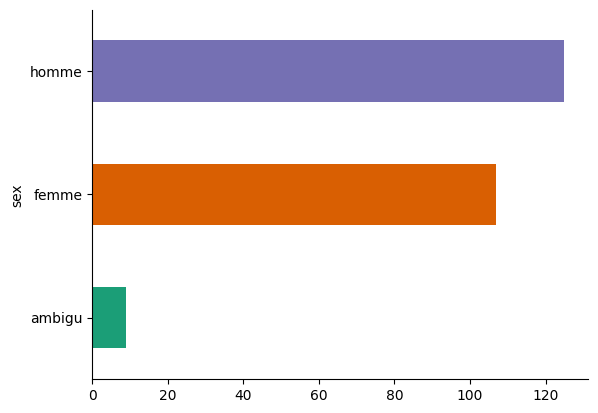

In [10]:
df_statdes.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
# Nbre de valeurs manquantes par information
df_statdes.isna().sum()

prénom               0
nom                 12
éducation          238
relation            86
employeur          206
date_naissance       1
profession         181
lieux_naissance     64
état_civil         204
sex                  0
dtype: int64

In [12]:
# Nbre de valeurs uniques par variables ainsi que les valeurs les plus fréquentes et leurs fréquences
df_statdes.describe()

,prénom,nom,éducation,relation,employeur,date_naissance,profession,lieux_naissance,état_civil,sex
count,241,229,3,155,35,240,60,177,37,241
unique,105,196,1,70,27,135,44,87,19,3
top,Marie,d,m,chef,patron,55,id,id,m,homme
freq,29,10,3,24,6,6,9,30,5,125


In [13]:
# Valeurs uniques et comptage de ces valeurs pour chaque variable

for col in df_statdes.columns:
    value_counts = df_statdes[col].value_counts()
    print(f"Value counts pour la colonne '{col}':\n{value_counts}\n")

Value counts pour la colonne 'prénom':
prénom
Marie         29
Jean          24
Louis         10
Marguerite     9
Jeanne         9
              ..
Alphonse       1
Herandre       1
Vaude          1
Oarguerite     1
Alexandre      1
Name: count, Length: 105, dtype: int64

Value counts pour la colonne 'nom':
nom
d            10
Dumont        7
Lacroix       3
Aubouier      3
Chardon       2
             ..
Boueulat      1
Dicharne      1
Chopelier     1
Burnas        1
Renaut        1
Name: count, Length: 196, dtype: int64

Value counts pour la colonne 'éducation':
éducation
m    3
Name: count, dtype: int64

Value counts pour la colonne 'relation':
relation
chef       24
id          8
fils        7
femme       6
d           5
           ..
Par         1
patron      1
sa          1
ouvrier     1
par         1
Name: count, Length: 70, dtype: int64

Value counts pour la colonne 'employeur':
employeur
patron        6
21399         2
Labrye        2
P             2
ahef          1
Bonnechon 

L'objectif étant de prédire le sexe de l'individu à partir de ses informations, il semblerait que pas toutes les informations sont fiables. C'est le cas notamment des informations employeur, état_civil et profession, pour lesquelles nous avons beaucoup de valeurs manquantes. De plus, lorsque nous regardons plus en détail les valeurs de état_civil et emplyeur qui ne sont pas manquantes, la plupart n'ont aucun sens, ceci explique pourquoi nous avons presque le même nombre de valeurs que de valeurs uniques pour ces caractéristiques. Les variables date_naissance et lieu_naissance présentent aussi beaucoup de valeurs sans sens, ce qui explique le nombre important de valeurs uniques pour ces variables. Par exemple:

In [14]:
df_statdes['état_civil'].unique()

array([None, 's', 'D', 'id', 'v', 'mère', 'm', 'Cheus', 'Chef', 'C', 'me',
       'M', 'S', 'sse', 'Vitant', 'V', 'meunicien', 'marns', 'Ch',
       'marnt'], dtype=object)

In [15]:
df_statdes['date_naissance'].unique()

array(['30', '67', '55', '1875', '78', '51', '9', '12', '4', '28', '1834',
       '53', '46', '33', '72', '21', '180n', '81', '6', '1886', '15',
       '42', '62', '1900', '1881', '1110e', '60', '24', '1852', '61',
       '29', '52', '9ar3', '6han', '17', '82', None, '86', '14', '74',
       '1904', '88', '1892', '63', '64', '66', '25', '3', '1899', '7',
       '58', '1804', '3903', '56', '54', '27', '1909', '9013', '71',
       '7904', '22', 'a4s', '5', '13', '10', '1906', '96', '57', '1894',
       '2an0', '1896', 'il', '20', '2', '1884', 'Parnen', '644ann', '85',
       '1883', '11', '75', '1907', '4903', '1922', '43', '1854', '1913',
       '1891', '1908', '84', '1887', '1924', '47', '0', '41', '69', '1',
       '920nn', '26', '49', '1890', '77', 'Plan', '36', '1897', '1204',
       '1879', '38', '68', '1917', '1863', '155a', '90', '01', '35',
       '1877', '59', '40', '18', '23', '19', '99nie', '1303', '16',
       '1898', '50', 'Jans', '39', '65', '1901', '1912', '12anx', '87',


In [16]:
df_statdes['profession'].unique()

array([None, 'métro', 'id', 'patron', 'cuisinière', 'domestique',
       'culviciste', 'd', 'voiturier', 'Ed', 'Domestique', 'sp',
       'enttinateur', 'sans', 'entiiiateur', 'emp', 'Turaliste', 'Cleve',
       'charentier', 'sellier', 'manoeuvre', 'polisseur', 'Employé',
       'journalier', 'Lameau', 'charesier', 'métag', 'repasseuse',
       'culsinière', 'san', 'naveur', 'D', 'S', 'lavane', 'Menuisier',
       'eublinateur', 'Louv', 'represt', 'Menseuvr', 'profevitaire',
       'entiinateur', 'href', 'Cubsinière', 'eublinat', 'fils'],
      dtype=object)

In [17]:
# on crée un dataframe qui rassemble toutes les informations en une colonne, et le sexe dans une autre

# on remplace des valeurs manquantes par des espaces vides str
df_statdes.replace(np.nan, '', inplace=True)

cols = df_statdes.drop(columns = ['date_naissance', 'sex']).columns
df_last = df_statdes[cols[0]]

for i in range(1, len(cols)-1):
  df_last = df_last + ' ' + df_statdes[cols[i+1]]

df_last = pd.concat([df_last, df_statdes['sex']], axis = 1)
df_last.columns = ['prediction', 'sex']

In [18]:
df_last.sample(5)

,prediction,sex
81,Marie prof C m,femme
165,Marie Empl,femme
48,Joséphine argentière Loire,femme
240,Antoinette belle Rigny,femme
193,Marthy,femme


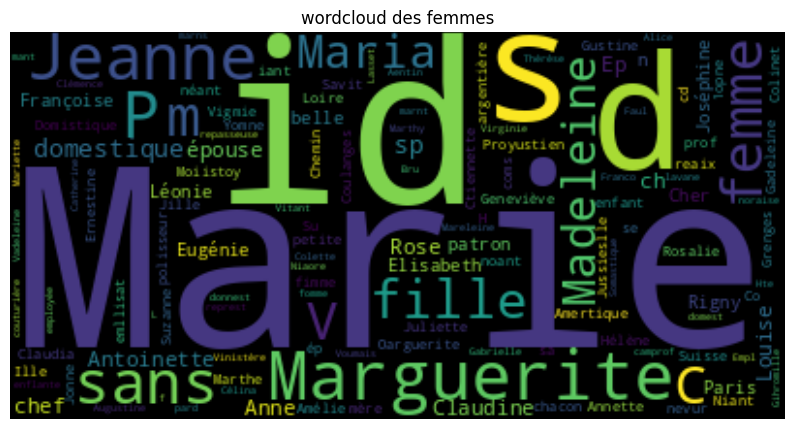

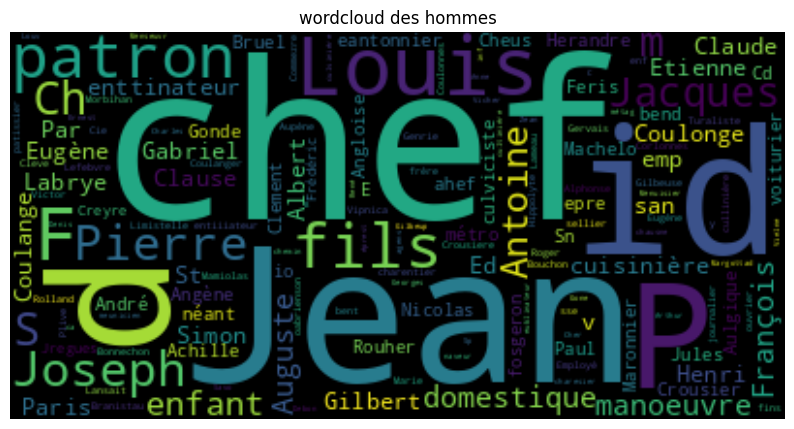

In [19]:
# wordcloud respectifs pour femmes et hommes de leurs données personnelles
for sex in ['femme', 'homme']:

  text_sex = df_last[df_last['sex'] == sex]['prediction']
  text_ = ' '.join([text.strip(' ').strip('"') for text in text_sex])

  wordcloud = WordCloud(background_color="black").generate(text_)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'wordcloud des {sex}s')
  plt.show()

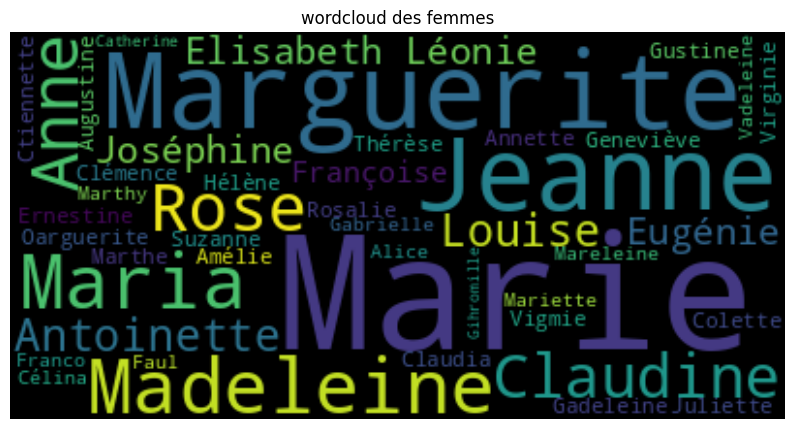

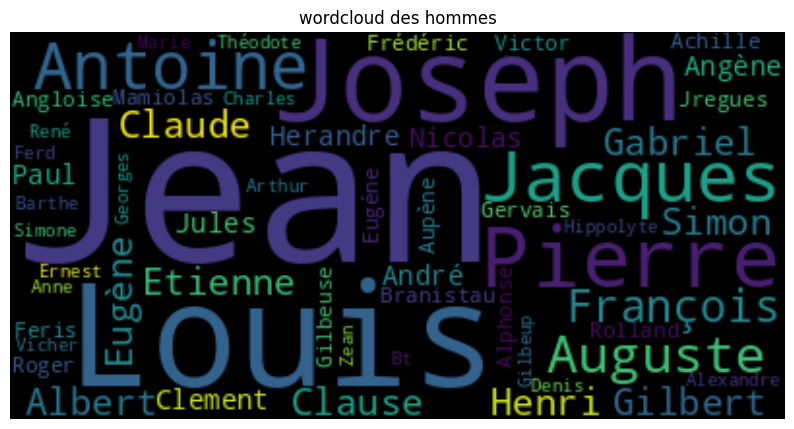

In [20]:
# words clouds respectifs pour femmes et hommes de prénoms

for sex in ['femme', 'homme']:

  text_sex = df_statdes[df_statdes['sex'] == sex]['prénom'].dropna()
  text_ = ' '.join([text.strip(' ').strip('"') for text in text_sex])

  wordcloud = WordCloud(background_color="black").generate(text_)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'wordcloud des {sex}s')
  plt.show()

In [21]:
# Individus dont le sexe est marqué comme ambigu
df_statdes[df_statdes['sex']=='ambigu']

,prénom,nom,éducation,relation,employeur,date_naissance,profession,lieux_naissance,état_civil,sex
17,Claude,Demil,,chef,,33,,Yonne,,ambigu
59,Jeanne,Gorbinet,,id,,66,,id,,ambigu
94,Vaude,Roumeau,,Chef,,1804,,Aulpares,,ambigu
123,Marie,Chardon,,D,,84,,,,ambigu
124,Emile,d,,,,2,,d,,ambigu
130,Marie,Martin,,,,47,id,P,id,ambigu
196,Claude,Pirot,,enfant,,1303,,id,,ambigu
204,Entonie,d,,f,,16,,d,,ambigu
230,Claude,Clayeux,,a,,13,,P,,ambigu


In [22]:
# Nous utilisons la base de fréquences des prénoms pour attribuer aux individus de sexe marqué comme ambigu
#m le sexe "homme" ou bien "femme", en fonction de la fréquence du sexe attribuée à chaque prénom dans la base de fréquences


for i in df_statdes[df_statdes['sex']=='ambigu']['prénom'].index:

  prenom = df_statdes.iloc[i]['prénom'].lower()

  if prenom != 'vaude' and prenom!= 'entonie': # ces noms n'existent pas, on les élimine de la base
    prob_homme = df_name[df_name['firstname']==prenom]['male'].values[0]
    prob_femme = df_name[df_name['firstname']==prenom]['female'].values[0]
    if prob_homme > prob_femme: # si fréquence d'hommes portant ce nom et plus élevé à la fréquence de femmes
      df_last.iloc[i]['sex'] = 'homme' # on attribue homme
      df_statdes.iloc[i]['sex'] = 'homme'
    else:
      df_last.iloc[i]['sex'] = 'femme' # sinon on attribue femme
      df_statdes.iloc[i]['sex'] = 'femme'

<ipython-input-22-38a268e0149a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statdes.iloc[i]['sex'] = 'homme'
<ipython-input-22-38a268e0149a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statdes.iloc[i]['sex'] = 'femme'


In [23]:
#on elimine les lignes pour lesquelles nous avons pas réussi de matcher les prénoms avec un sexe

delete_index = df_statdes[df_statdes['sex']=='ambigu'].index
df_last = df_last.drop(index = delete_index)
df_statdes = df_statdes.drop(index = delete_index)

## Partie 1: Vectorisation Counter et TF-IDF, et naive bayesian pour prédire le sexe de l'individu

### En utilisant que les noms et prenoms

In [40]:
X = df_statdes['prénom']
Y = df_statdes['sex']

X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, train_size = 0.8, random_state = 42)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_not_train, Y_not_train, test_size = 0.5)

In [45]:
# Crétion du vectorizer
vectorizer  = CountVectorizer(max_features = 1010)

# Vectorisation du texte
vectorizer.fit(X_train)

# Entrainement du Naive Bayesian
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)

clf_idf = MultinomialNB()
clf_idf.fit(X_train_counts, Y_train)

# Resultats
acc_test = clf_idf.score(X_test_counts, Y_test.values)
acc_train = clf_idf.score(X_train_counts, Y_train.values)
acc_dev = clf_idf.score(X_dev_counts, Y_dev.values)
print(acc_train, acc_test, acc_dev)

0.9891891891891892 0.8695652173913043 0.875


In [44]:
# transfornation des vecteurs de comptage en vecteurs de fréquence TF-IDF
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
X_dev_tf = tf_transformer.transform(X_dev_counts)

# train a Naive Bayes classifier

clf_idf_tf = MultinomialNB()
clf_idf_tf.fit(X_train_tf, Y_train)

Y_pred_test = clf_idf_tf.predict(X_test_tf)
Y_pred_train = clf_idf_tf.predict(X_train_tf)

acc_test = clf_idf_tf.score(X_test_tf, Y_test.values)
acc_train = clf_idf_tf.score(X_train_tf, Y_train.values)
acc_dev = clf_idf_tf.score(X_dev_tf, Y_dev.values)
print(acc_train, acc_test, acc_dev)

0.9891891891891892 0.8695652173913043 0.875


### Avec toutes les données

##### Count Vectorizer

In [53]:
# Fonction Grid Search pour choisir le nombre de mots pris en compte par le vectorizer
def grid_search_counter(X_train, X_test, Y_train, Y_test, transformer = False, max_parameter = 6000):

    """ On fait un gread_search sur le nombre de mots utilisés dans la vectorisation

    Args:
        X_train (_type_): _description_
        X_test (_type_): _description_
        Y_train (_type_): _description_
        Y_train (_type_): _description_
        transformer (bool, optional): _description_. Defaults to False.
    """
    acc = 0
    f = 0

    for max_f in np.arange(10,max_parameter, int(max_parameter/10)):

        # create the vectorizer object
        vectorizer  = CountVectorizer(max_features=max_f)

        # fit on train data
        vectorizer.fit(X_train)

        # apply it on train and dev data
        X_train_counts = vectorizer.transform(X_train)
        X_test_counts = vectorizer.transform(X_test)

        if transformer == True:

            tf_transformer = TfidfTransformer().fit(X_train_counts)

            X_train_counts = tf_transformer.transform(X_train_counts)
            X_test_counts = tf_transformer.transform(X_test_counts)


        clf = MultinomialNB()
        clf.fit(X_train_counts, Y_train)

        acc_test = clf.score(X_test_counts, Y_test.values)

        if acc_test > acc:

            acc = acc_test
            f = max_f


    return acc, f



In [54]:
X = df_last['prediction']
Y = df_last['sex']

X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, train_size = 0.8, random_state = 42)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_not_train, Y_not_train, test_size = 0.5)

In [55]:
grid_search_counter(X_train, X_test, Y_train, Y_test, transformer = False, max_parameter= 5000)

(0.9130434782608695, 510)

In [56]:
grid_search_counter(X_train, X_test, Y_train, Y_test, transformer = True, max_parameter= 5000)

(0.9565217391304348, 510)

In [57]:
# Crétion du vectorizer
vectorizer  = CountVectorizer(max_features = 1010)

# Vectorisation du texte
vectorizer.fit(X_train)

# Entrainement du Naive Bayesian
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)

clf_idf = MultinomialNB()
clf_idf.fit(X_train_counts, Y_train)

# Resultats
acc_test = clf_idf.score(X_test_counts, Y_test.values)
acc_train = clf_idf.score(X_train_counts, Y_train.values)
acc_dev = clf_idf.score(X_dev_counts, Y_dev.values)
print(acc_train, acc_test, acc_dev)

0.9783783783783784 0.9130434782608695 0.875


##### TF-IDF

In [58]:
# transfornation des vecteurs de comptage en vecteurs de fréquence TF-IDF
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)
X_dev_tf = tf_transformer.transform(X_dev_counts)

# train a Naive Bayes classifier

clf_idf_tf = MultinomialNB()
clf_idf_tf.fit(X_train_tf, Y_train)

Y_pred_test = clf_idf_tf.predict(X_test_tf)
Y_pred_train = clf_idf_tf.predict(X_train_tf)

acc_test = clf_idf_tf.score(X_test_tf, Y_test.values)
acc_train = clf_idf_tf.score(X_train_tf, Y_train.values)
acc_dev = clf_idf_tf.score(X_dev_tf, Y_dev.values)
print(acc_train, acc_test, acc_dev)

0.9945945945945946 0.9565217391304348 0.875


En ayant appliqué la vectorisation par comptage et puis le tf-idf, nous pouvons observer que les résultats se sont améliorés lorsqu'on utilise tout le texte disponible. Sachant que le nombre de mots dans chaque document (ligne d'information pour un individu) est limité à des prénoms pour le deuxième cas, nous utilisons tous les mots (max_features n'est pas modifié). De plus, le naive bayes overfitt sur le countvector et le tf-idf, avec des accuracy bien plus grandes sur le train test. Lorsque l'on utilise toute l'information et pas seulement les prénoms, il semblerait que cet effet de overfitting est moindre mais toujours présent. A continuation, nous regardons comment l'utilisation du CamemBERT pré-entraîné pourrait nous aider. En effet, vu que le nombre de données disponibles n'est pas très élevé, la prédiction du sex de l'individu pourrait bénéficier de l'utilisation d'un modèle pré-entrainé tel que CamemBERT.

## Partie 2: Utilisation de  CamemBERT pour le même exercice

In [24]:
from transformers import CamembertTokenizerFast, CamembertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [27]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### Avec que les prénoms

In [78]:
X = df_statdes['prénom'].to_list()
Y = df_statdes['sex'].replace('homme', 1).replace('femme', 0).to_list()

X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, train_size = 0.8, random_state = 42, shuffle = True)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_not_train, Y_not_train, test_size = 0.5)

# Tokenisation des données
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

train_encodings = tokenizer(X_train, truncation=True, padding=True)
dev_encodings = tokenizer(X_dev, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

train_dataset = IMDbDataset(train_encodings, Y_train)
dev_dataset = IMDbDataset(dev_encodings, Y_dev)
test_dataset = IMDbDataset(test_encodings,Y_test)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 3
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

In [79]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=2)

# Configuration de l'optimiseur
optim = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(3):

    for batch in train_loader:

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask = attention_mask, labels=labels)
        loss = outputs[0]

        loss.backward()
        optim.step()


model.eval()
dev_preds = []
dev_true = []

with torch.no_grad():
    for batch in dev_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        dev_preds.extend(preds)
        dev_true.extend(labels.cpu().numpy())

test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
dev_accuracy = accuracy_score(dev_true, dev_preds)
test_accuracy = accuracy_score(test_true, test_preds)
print(f"Development accuracy: {dev_accuracy:.4f}", f"Test accuracy: {test_accuracy:.4f}")

Development accuracy: 0.9167 Test accuracy: 0.9565


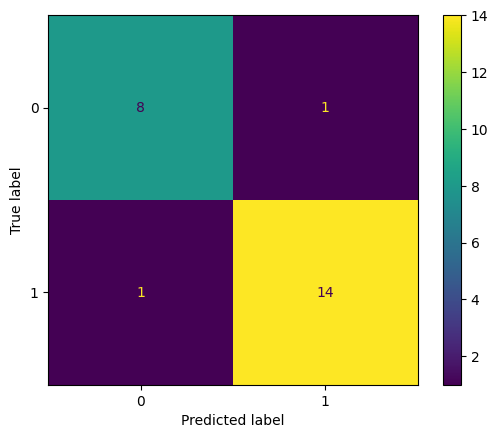

In [81]:
# On calcule la matrice de confusion pour le dev set
cm = confusion_matrix(dev_true, dev_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

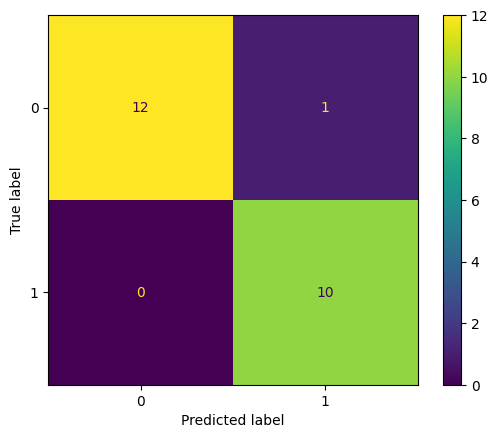

In [82]:
# On calcule la matrice de confusion pour le test set
cm = confusion_matrix(test_true, test_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

### Avec les données jugées de bonne qualité: prénom, profession, relation

In [28]:
cols = ['prénom', 'relation', 'profession']
df_good = df_statdes[cols[0]]

for i in range(1, len(cols)-1):
  df_good = df_good + ' ' + df_statdes[cols[i+1]]

df_good = pd.concat([df_good, df_statdes['sex']], axis = 1)
df_good.columns = ['prediction', 'sex']

In [29]:
X = df_good['prediction'].to_list()
Y = df_good['sex'].replace('homme', 1).replace('femme', 0).to_list()

X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, train_size = 0.8, random_state = 42, shuffle = True)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_not_train, Y_not_train, test_size = 0.5)

# Tokenisation des données
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

train_encodings = tokenizer(X_train, truncation=True, padding=True)
dev_encodings = tokenizer(X_dev, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

train_dataset = IMDbDataset(train_encodings, Y_train)
dev_dataset = IMDbDataset(dev_encodings, Y_dev)
test_dataset = IMDbDataset(test_encodings,Y_test)

# Paramètres d'entraînement
batch_size = 16
num_epochs = 3
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size)

In [30]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=2)

# Configuration de l'optimiseur
optim = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(3):

    for batch in train_loader:

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask = attention_mask, labels=labels)
        loss = outputs[0]

        loss.backward()
        optim.step()


model.eval()
dev_preds = []
dev_true = []

with torch.no_grad():
    for batch in dev_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        dev_preds.extend(preds)
        dev_true.extend(labels.cpu().numpy())

test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
dev_accuracy = accuracy_score(dev_true, dev_preds)
test_accuracy = accuracy_score(test_true, test_preds)
print(f"Development accuracy: {dev_accuracy:.4f}", f"Test accuracy: {test_accuracy:.4f}")

Development accuracy: 0.9583 Test accuracy: 0.9565


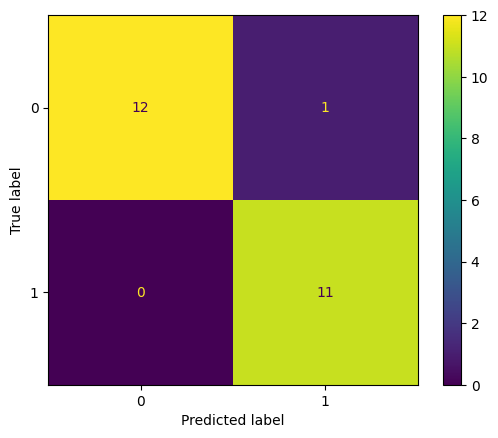

In [32]:
# On calcule la matrice de confusion pour le dev set
cm = confusion_matrix(dev_true, dev_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

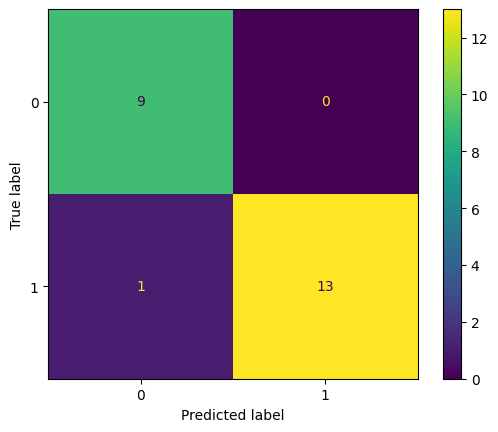

In [33]:
# On calcule la matrice de confusion pour le test set
cm = confusion_matrix(test_true, test_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

### Avec toutes les données

In [68]:
X = df_last['prediction'].to_list()
Y = df_last['sex'].replace('homme', 1).replace('femme', 0).to_list()

X_train, X_not_train, Y_train, Y_not_train = train_test_split(X, Y, train_size = 0.8, random_state = 42, shuffle = True)

X_test, X_dev, Y_test, Y_dev = train_test_split(X_not_train, Y_not_train, test_size = 0.5)

In [69]:
# Tokenisation des données
tokenizer = CamembertTokenizerFast.from_pretrained('camembert-base')

train_encodings = tokenizer(X_train, truncation=True, padding=True)
dev_encodings = tokenizer(X_dev, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [70]:
train_dataset = IMDbDataset(train_encodings, Y_train)
dev_dataset = IMDbDataset(dev_encodings, Y_dev)
test_dataset = IMDbDataset(test_encodings,Y_test)

In [71]:
# Paramètres d'entraînement
batch_size = 16
num_epochs = 3
learning_rate = 2e-5

# Création des dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle = True)

In [72]:
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=2)

# Configuration de l'optimiseur
optim = AdamW(model.parameters(), lr=learning_rate)

# Entraînement du modèle
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(3):

    for batch in train_loader:

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask = attention_mask, labels=labels)
        loss = outputs[0]

        loss.backward()
        optim.step()


model.eval()
dev_preds = []
dev_true = []

with torch.no_grad():
    for batch in dev_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        dev_preds.extend(preds)
        dev_true.extend(labels.cpu().numpy())

test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(labels.cpu().numpy())


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
dev_accuracy = accuracy_score(dev_true, dev_preds)
test_accuracy = accuracy_score(test_true, test_preds)
print(f"Development accuracy: {dev_accuracy:.4f}", f"Test accuracy: {test_accuracy:.4f}")

Development accuracy: 0.9167 Test accuracy: 0.9565


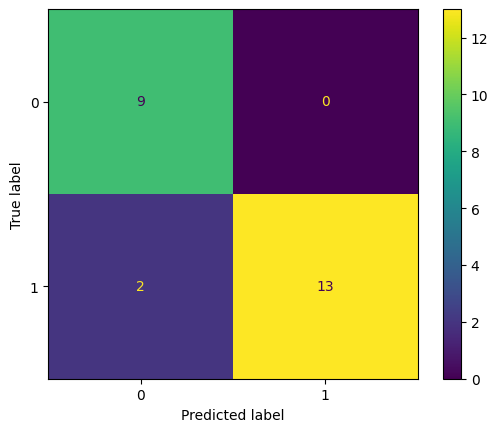

In [74]:
# On calcule la matrice de confusion pour le dev set
cm = confusion_matrix(dev_true, dev_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

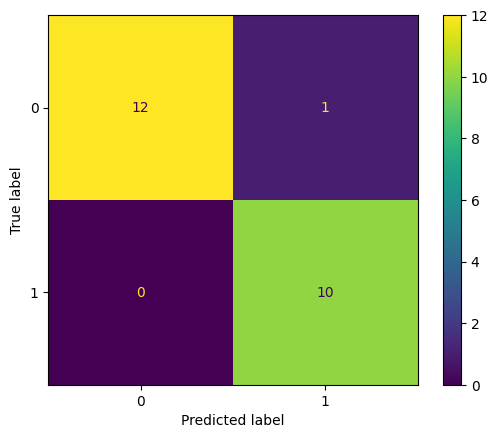

In [75]:
# On calcule la matrice de confusion pour le test set
cm = confusion_matrix(test_true, test_preds)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()